<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/sg_mcmc_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SG-MCMC-JAX library

https://github.com/jeremiecoullon/SGMCMCJax



#Setup

In [2]:
# If running in TPU mode
import jax.tools.colab_tpu

jax.tools.colab_tpu.setup_tpu()

In [1]:
%%capture
!pip install sgmcmcjax

In [3]:
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, random

print(jax.__version__)
print(jax.devices())

0.2.19
[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [4]:
from sgmcmcjax.samplers import build_sgld_sampler
from sgmcmcjax.kernels import build_sgld_kernel, build_psgld_kernel, build_sgldAdam_kernel, build_sghmc_kernel

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

key = random.PRNGKey(0)

# Gaussian posterior

https://sgmcmcjax.readthedocs.io/en/latest/nbs/gaussian.html

In [5]:
# define model in JAX
def loglikelihood(theta, x):
    return -0.5 * jnp.dot(x - theta, x - theta)


def logprior(theta):
    return -0.5 * jnp.dot(theta, theta) * 0.01


# generate dataset
N, D = 10_000, 100
key = random.PRNGKey(0)
mu_true = random.normal(key, shape=(D,))
X_data = random.normal(key, shape=(N, D)) + mu_true

# build sampler
batch_size = int(0.1 * N)
dt = 1e-5
my_sampler = build_sgld_sampler(dt, loglikelihood, logprior, (X_data,), batch_size)

In [9]:
%%time 
Nsamples = 10_000
samples = my_sampler(key, Nsamples, jnp.zeros(D))




  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2.33 s, sys: 28.3 ms, total: 2.36 s
Wall time: 2.15 s


In [13]:
print(samples.shape)
mu_est = jnp.mean(samples, axis=0)
print(jnp.allclose(mu_true, mu_est, atol=1e-1))
print(mu_true[:10])
print(mu_est[:10])

(10000, 100)
True
[-1.9810703   1.0481724   0.8898191   0.035166   -0.9473585   0.85125655
  0.0312455  -0.38968593  0.01320801 -0.42052191]
[-1.978512    1.0331445   0.89015543  0.03904775 -0.932177    0.84927595
  0.02497404 -0.40603572  0.0154047  -0.42717296]


In [8]:
data = (X_data,)
init_fn, sgld_kernel, get_params = build_sgld_kernel(dt, loglikelihood, logprior, data, batch_size)


key, subkey = random.split(key)
params = random.normal(subkey, shape=(D,))

key, subkey = random.split(key)
state = init_fn(subkey, params)
print(state)

RuntimeError: ignored

# Logistic regression

https://sgmcmcjax.readthedocs.io/en/latest/nbs/logistic_regression.html

In [14]:
from models.logistic_regression import gen_data, loglikelihood, logprior

key = random.PRNGKey(42)
dim = 10
Ndata = 100000

theta_true, X, y_data = gen_data(key, dim, Ndata)

ModuleNotFoundError: ignored

# Bayesian neural network

https://sgmcmcjax.readthedocs.io/en/latest/nbs/BNN.html

In [15]:
from models.bayesian_NN.NN_data import X_train, X_test, y_train, y_test
from models.bayesian_NN.NN_model import init_network, loglikelihood, logprior, accuracy

from sgmcmcjax.kernels import build_sgld_kernel
from tqdm.auto import tqdm

ModuleNotFoundError: ignored

# FLAX CNN

https://sgmcmcjax.readthedocs.io/en/latest/nbs/Flax_MNIST.html

In [5]:
%%capture
!pip install --upgrade git+https://github.com/google/flax.git

In [6]:
import tensorflow_datasets as tfds

from flax import linen as nn

In [7]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

In [8]:
cnn = CNN()


def loglikelihood(params, x, y):
    x = x[jnp.newaxis]  # add an axis so that it works for a single data point
    logits = cnn.apply({"params": (params)}, x)
    label = jax.nn.one_hot(y, num_classes=10)
    return jnp.sum(logits * label)


def logprior(params):
    return 1.0


@jit
def accuracy_cnn(params, X, y):
    target_class = y
    predicted_class = jnp.argmax(cnn.apply({"params": (params)}, X), axis=1)
    return jnp.mean(predicted_class == target_class)


def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder("mnist")
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))
    train_ds["image"] = jnp.float32(train_ds["image"]) / 255.0
    test_ds["image"] = jnp.float32(test_ds["image"]) / 255.0
    return train_ds, test_ds


train_ds, test_ds = get_datasets()

X_train_s = train_ds["image"]
y_train_s = jnp.array(train_ds["label"])
X_test_s = test_ds["image"]
y_test_s = jnp.array(test_ds["label"])


data = (X_train_s, y_train_s)
batch_size = int(0.01 * data[0].shape[0])
print(batch_size)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
600


In [9]:
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))
print(params.keys())
params = params["params"]
print(params["Dense_0"]["kernel"].shape)
print(params["Dense_1"]["kernel"].shape)

frozen_dict_keys(['params'])
(3136, 256)
(256, 10)


In [10]:
def run_sgmcmc(key, Nsamples, init_fn, my_kernel, get_params, record_accuracy_every=50):
    "Run SGMCMC sampler and return the test accuracy list"
    accuracy_list = []
    params = cnn.init(key, jnp.ones([1, 28, 28, 1]))["params"]
    key, subkey = random.split(key)
    state = init_fn(subkey, params)

    for i in tqdm(range(Nsamples)):
        key, subkey = random.split(key)
        state = my_kernel(i, subkey, state)
        if i % record_accuracy_every == 0:
            test_acc = accuracy_cnn(get_params(state), X_test_s, y_test_s)
            accuracy_list.append((i, test_acc))

    return accuracy_list

In [25]:
kernel_dict = {}

# SGLD
init_fn, kernel, get_params = build_sgld_kernel(5e-6, loglikelihood, logprior, data, batch_size)
kernel = jit(kernel)
kernel_dict["sgld"] = (init_fn, kernel, get_params)

# SG-HMC
init_fn, kernel, get_params = build_sghmc_kernel(
    1e-6, 4, loglikelihood, logprior, data, batch_size, compiled_leapfrog=False
)
kernel = jit(kernel)
kernel_dict["sghmc"] = (init_fn, kernel, get_params)

# PSGLD
init_fn, kernel, get_params = build_psgld_kernel(1e-3, loglikelihood, logprior, data, batch_size)
kernel = jit(kernel)
kernel_dict["psgld"] = (init_fn, kernel, get_params)

# SGLD-Adam
init_fn, kernel, get_params = build_sgldAdam_kernel(1e-2, loglikelihood, logprior, data, batch_size)
kernel = jit(kernel)
kernel_dict["sgldAdam"] = (init_fn, kernel, get_params)

In [26]:
Nsamples = 500
acc_dict = {}

for (name, fns) in kernel_dict.items():
    print(name)
    init_fn, kernel, get_params = fns
    accuracy_list = run_sgmcmc(random.PRNGKey(0), Nsamples, init_fn, kernel, get_params)
    print(accuracy_list)
    acc_dict[name] = accuracy_list

sgld


  0%|          | 0/500 [00:00<?, ?it/s]

[(0, DeviceArray(0.2977, dtype=float32)), (50, DeviceArray(0.85209996, dtype=float32)), (100, DeviceArray(0.94479996, dtype=float32)), (150, DeviceArray(0.9546, dtype=float32)), (200, DeviceArray(0.9641, dtype=float32)), (250, DeviceArray(0.84499997, dtype=float32)), (300, DeviceArray(0.97099996, dtype=float32)), (350, DeviceArray(0.97129995, dtype=float32)), (400, DeviceArray(0.979, dtype=float32)), (450, DeviceArray(0.9744, dtype=float32))]
sghmc


  0%|          | 0/500 [00:00<?, ?it/s]

[(0, DeviceArray(0.2218, dtype=float32)), (50, DeviceArray(0.8204, dtype=float32)), (100, DeviceArray(0.94579995, dtype=float32)), (150, DeviceArray(0.96419996, dtype=float32)), (200, DeviceArray(0.9719, dtype=float32)), (250, DeviceArray(0.9691, dtype=float32)), (300, DeviceArray(0.9741, dtype=float32)), (350, DeviceArray(0.96419996, dtype=float32)), (400, DeviceArray(0.97919995, dtype=float32)), (450, DeviceArray(0.97849995, dtype=float32))]
psgld


  0%|          | 0/500 [00:00<?, ?it/s]

[(0, DeviceArray(0.0822, dtype=float32)), (50, DeviceArray(0.4951, dtype=float32)), (100, DeviceArray(0.69009995, dtype=float32)), (150, DeviceArray(0.77989995, dtype=float32)), (200, DeviceArray(0.8257, dtype=float32)), (250, DeviceArray(0.8641, dtype=float32)), (300, DeviceArray(0.8815, dtype=float32)), (350, DeviceArray(0.89559996, dtype=float32)), (400, DeviceArray(0.9091, dtype=float32)), (450, DeviceArray(0.9166, dtype=float32))]
sgldAdam


  0%|          | 0/500 [00:00<?, ?it/s]

[(0, DeviceArray(0.0804, dtype=float32)), (50, DeviceArray(0.31579998, dtype=float32)), (100, DeviceArray(0.5855, dtype=float32)), (150, DeviceArray(0.6836, dtype=float32)), (200, DeviceArray(0.731, dtype=float32)), (250, DeviceArray(0.7471, dtype=float32)), (300, DeviceArray(0.78779995, dtype=float32)), (350, DeviceArray(0.7556, dtype=float32)), (400, DeviceArray(0.79749995, dtype=float32)), (450, DeviceArray(0.7644, dtype=float32))]


Text(0, 0.5, 'Test accuracy')

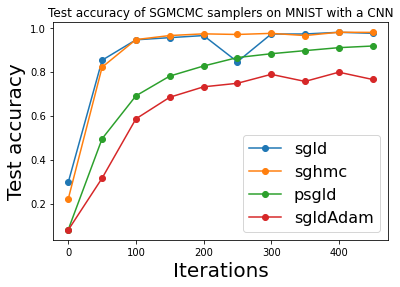

In [27]:
plt.figure()
for name, acc_list in acc_dict.items():
    steps = [s for (s, a) in acc_list]
    accs = [a for (s, a) in acc_list]
    plt.plot(steps, accs, "-o", label=name)

plt.legend(fontsize=16)
plt.title("Test accuracy of SGMCMC samplers on MNIST with a CNN")
plt.xlabel("Iterations", size=20)
plt.ylabel("Test accuracy", size=20)